# Numerical Analysis
In this interactive Notebook both the simulation and the deterministic algorithms are assessed on their numerical precision.

In [602]:
# Libraries used in the interactive Notebook
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm

In [603]:
# The seed for the probabilistic functions
SEED = sum([ord(c) for c in "Social Networks Lab"])

In [604]:
# These are the algorithms, which we are assessing
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            #random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

In [605]:
# Non-float code
# Precision in 10^-x
PRECISION = 4

def collapse(num):
    num_str = str(num[0])
    exponent_shift = 0
    for c in reversed(num_str):
        if c != '0':
            break
        exponent_shift += 1
    return (int(num_str[:len(num_str)-exponent_shift]), num[1]+exponent_shift)

def floatstring_to_tf(s):
    # Get decimal point index
    point_index = s.find('.')
    decimals_string = ''
    exponent = 0
    for c in s[point_index+1:]:
        decimals_string += c
        exponent -= 1
    return (int(s[:point_index]+decimals_string), exponent)

def truncate_float_to_precision(f, precision=PRECISION):
    fs = str(f)
    point_index = fs.find('.')
    return float(fs[:point_index+precision+1])

def float_to_tf(f):
    return floatstring_to_tf(str(truncate_float_to_precision(f)))

def scaled_minus(a, b, absolute=False):
    res = None
    if a[1] == b[1]:
        res = collapse((a[0]-b[0], a[1]))
    elif a[1] > b[1]:
        exp_shift = a[1]-b[1]
        res = collapse((int(str(a[0]) + '0'*exp_shift) - b[0], b[1]))
    else:
        exp_shift = b[1]-a[1]
        res = collapse((a[0] - int(str(b[0]) + '0'*exp_shift), a[1]))
    if absolute:
        return (abs(res[0]), res[1])
    else:
        return res

def scaled_plus(a, b):
    if a[1] == b[1]:
        return collapse((a[0]+b[0], a[1]))
    elif a[1] > b[1]:
        exp_shift = a[1]-b[1]
        return collapse((int(str(a[0]) + '0'*exp_shift) + b[0], b[1]))
    else:
        exp_shift = b[1]-a[1]
        return collapse((a[0] + int(str(b[0]) + '0'*exp_shift), a[1]))
    
def scaled_mult(a, b):
    return collapse((a[0]*b[0], a[1]+b[1]))

def dp_scaled(p_is):
    n = len(p_is)
    p_k = [(1, 0)] + [(0, 0)]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = scaled_mult(p_is[i-1], p_k[c-1])
            p_k[c-1] = scaled_minus(p_k[c-1], inc)
            p_k[c] = scaled_plus(p_k[c], inc)
    return p_k

In [606]:
def res_to_tf(res):
    return [floatstring_to_tf(f'{r:.40f}') for r in res]

# The machine precision
eps = np.finfo(float).eps
eps_tf = floatstring_to_tf(f'{eps:.40f}')
print(f'Machine precision is {eps}')
print(f'Machine precision in tuple format: {eps_tf}')

Machine precision is 2.220446049250313e-16
Machine precision in tuple format: (2220446049250313080847263, -40)


In [607]:
# Read the Possession xG values and group them by match id
xg_df = pd.read_pickle('possession_xGs.pkl')

In [608]:
samples = [truncate_float_to_precision(x) for x in xg_df.sample(11, replace=True, random_state=SEED)['possession_xg'].to_list()]
samples_transformed = [float_to_tf(x) for x in samples]

print(samples_transformed)
print(samples)

[(979, -4), (132, -3), (22, -3), (555, -4), (1337, -4), (307, -4), (962, -4), (657, -4), (116, -4), (521, -4), (213, -4)]
[0.0979, 0.132, 0.022, 0.0555, 0.1337, 0.0307, 0.0962, 0.0657, 0.0116, 0.0521, 0.0213]


In [609]:
# Run the algorithms
exact_res = dp_scaled(samples_transformed)
dp_res = res_to_tf(dp(samples))
fft_res = res_to_tf(fft(samples))
sim_res = simulation(samples, 10000)

In [610]:
sum(sim_res)

1.0

In [611]:
simulation([0.25]*11, 10000)

[0.0435,
 0.1599,
 0.2519,
 0.2576,
 0.1743,
 0.079,
 0.0279,
 0.0051,
 0.0006,
 0.0002,
 0.0,
 0.0]

In [612]:
# Calculate the errors
dp_error = [scaled_minus(r_dp, r_exact) for r_dp, r_exact in zip(dp_res, exact_res)]
fft_error = [scaled_minus(r_fft, r_exact) for r_fft, r_exact in zip(fft_res, exact_res)]

In [613]:
# Scale the dp_error and fft_error to same exponent
min_exp = min([e[1] for e in dp_error])
min_exp = min(min([e[1] for e in fft_error]), min_exp)

def scale_to_exponent(tf_list, min_exp):
    new_tf_list = []
    for mul, exp in tf_list:
        exp_shift = exp - min_exp
        new_tf_list.append((int(str(mul) + '0'*exp_shift), exp-exp_shift))
    return new_tf_list

dp_error = scale_to_exponent(dp_error, min_exp)
fft_error = scale_to_exponent(fft_error, min_exp)
# Also get a scaling of the machine precision
eps_graph = floatstring_to_tf(f'{np.finfo(float).eps:.100f}'[:-min_exp+2])
epsneg_graph = floatstring_to_tf(f'{np.finfo(float).epsneg:.100f}'[:-min_exp+2])

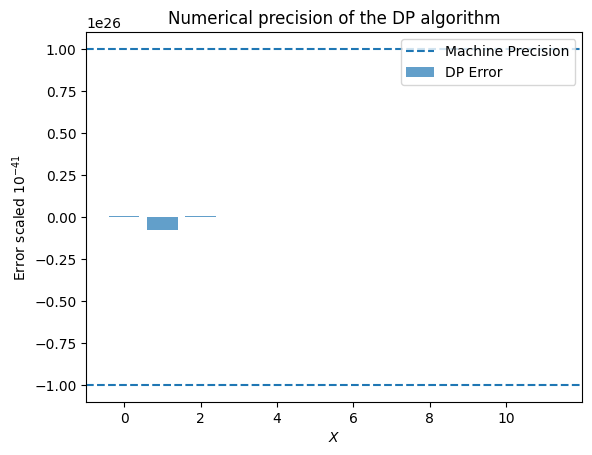

In [614]:
# Plot the error
dp_error = [t[0] for t in dp_error]
fft_error = [t[0] for t in fft_error]
plt.bar(range(len(samples)+1), dp_error, alpha=0.7, label='DP Error')
plt.title('Numerical precision of the DP algorithm')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()

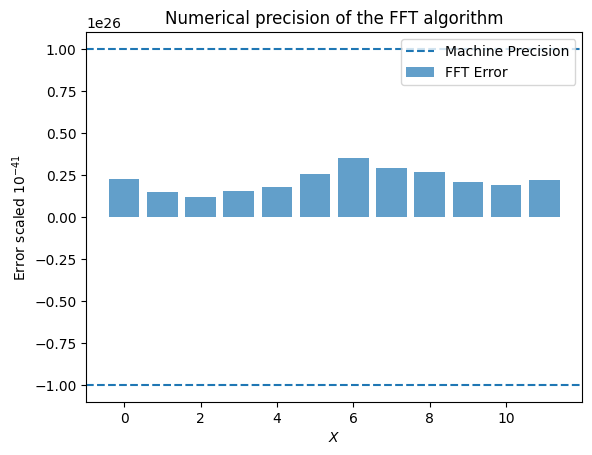

In [615]:
plt.clf()
plt.bar(range(len(samples)+1), fft_error, alpha=0.7, label='FFT Error')
plt.title('Numerical precision of the FFT algorithm')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()

In [616]:
samples_asc = sorted(samples)
samples_desc = list(reversed(samples_asc))
exact_res = dp_scaled(samples_transformed)
dp_asc = res_to_tf(dp(samples_asc))
dp_desc = res_to_tf(dp(samples_desc))
fft_asc = res_to_tf(fft(samples_asc))
fft_desc = res_to_tf(fft(samples_desc))

In [617]:
# Calculate the errors
dp_error_asc = [scaled_minus(r_dp, r_exact) for r_dp, r_exact in zip(dp_asc, exact_res)]
fft_error_asc = [scaled_minus(r_fft, r_exact) for r_fft, r_exact in zip(fft_asc, exact_res)]
dp_error_desc = [scaled_minus(r_dp, r_exact) for r_dp, r_exact in zip(dp_desc, exact_res)]
fft_error_desc = [scaled_minus(r_fft, r_exact) for r_fft, r_exact in zip(fft_desc, exact_res)]
dp_error_asc = scale_to_exponent(dp_error_asc, min_exp)
fft_error_asc = scale_to_exponent(fft_error_asc, min_exp)
dp_error_desc = scale_to_exponent(dp_error_desc, min_exp)
fft_error_desc = scale_to_exponent(fft_error_desc, min_exp)
dp_error_asc = [t[0] for t in dp_error_asc]
dp_error_desc = [t[0] for t in dp_error_desc]
fft_error_asc = [t[0] for t in fft_error_asc]
fft_error_desc = [t[0] for t in fft_error_desc]

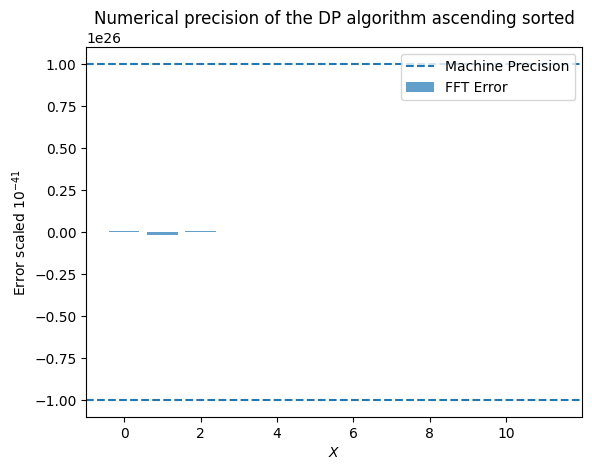

In [618]:
plt.clf()
plt.bar(range(len(samples)+1), dp_error_asc, alpha=0.7, label='FFT Error')
plt.title('Numerical precision of the DP algorithm ascending sorted')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()

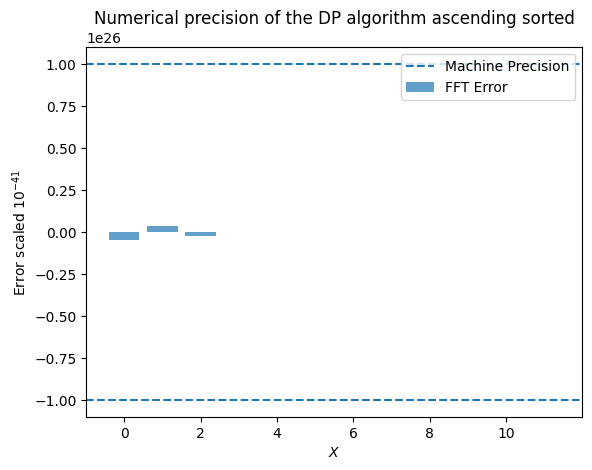

In [619]:
plt.clf()
plt.bar(range(len(samples)+1), dp_error_desc, alpha=0.7, label='FFT Error')
plt.title('Numerical precision of the DP algorithm ascending sorted')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()

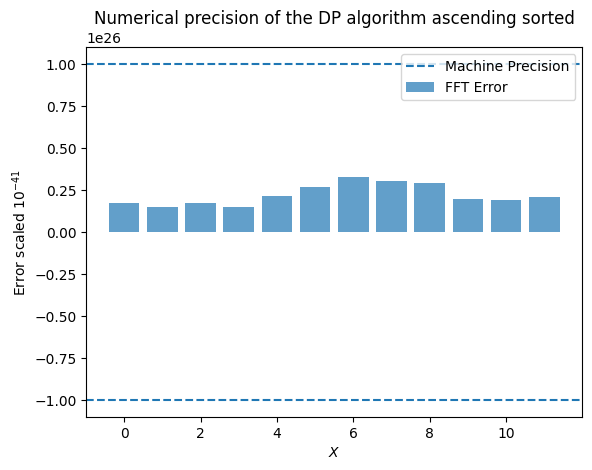

In [620]:
plt.clf()
plt.bar(range(len(samples)+1), fft_error_asc, alpha=0.7, label='FFT Error')
plt.title('Numerical precision of the DP algorithm ascending sorted')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()

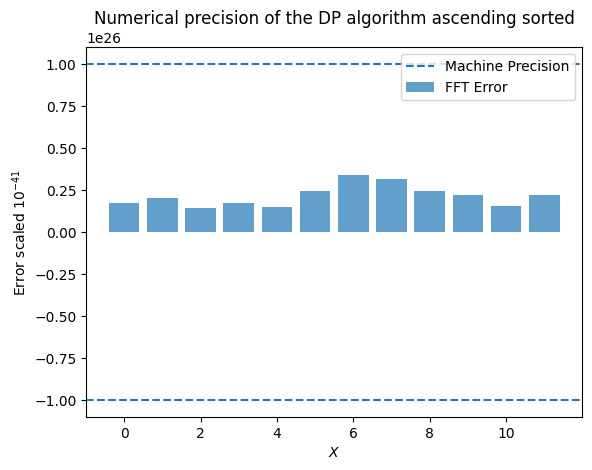

In [621]:
plt.clf()
plt.bar(range(len(samples)+1), fft_error_desc, alpha=0.7, label='FFT Error')
plt.title('Numerical precision of the DP algorithm ascending sorted')
plt.xlabel('$X$')
plt.ylabel(f'Error scaled $10^{"{" + str(min_exp) + "}"}$')
plt.axhline(eps_graph[0], linestyle='--', label='Machine Precision')
plt.axhline(-eps_graph[0], linestyle='--')
plt.legend()
plt.show()